In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
#| default_exp alg.mix_guassian

In [102]:
#| hide
from nbdev.showdoc import *

In [103]:
#| export
import numpy as np

In [104]:
#| export
import torch
import torch.nn as nn
import torch.distributions as dist

class MixtureOfGaussians(nn.Module):
    def __init__(self, n_components, n_features, low=-4.0, high=4.0):
        super(MixtureOfGaussians, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        self.means = nn.Parameter(torch.empty(n_components, n_features).uniform_(low, high))
        self.cov_factors = nn.Parameter(torch.stack([torch.tril(torch.eye(n_features)) for _ in range(self.n_components)]))
        self.log_weights = nn.Parameter(torch.zeros(n_components))

    @property
    def covariances(self):
        return torch.matmul(self.cov_factors, self.cov_factors.transpose(1, 2))

    @property
    def weights(self):
        return self.log_weights.softmax(dim=0)
    
    def forward(self, x):
        gaussians = [dist.MultivariateNormal(self.means[i], scale_tril=self.cov_factors[i]) \
                     for i in range(self.n_components)]
        log_probs = torch.stack([gaussian.log_prob(x) for gaussian in gaussians], dim=-1)
        log_probs = log_probs + self.log_weights.log_softmax(dim=0)
        return -torch.logsumexp(log_probs, dim=-1).mean()

    def _e_step(self, X):
        """Compute responsibilities (E-step)."""
        n_samples = X.shape[0]
        weights = self.log_weights.softmax(dim=0)  # Normalize weights
        responsibilities = torch.zeros(n_samples, self.n_components)
        
        for k in range(self.n_components):
            # Ensure positive-definiteness of covariance matrices
            mvn = dist.MultivariateNormal(self.means[k], scale_tril=self.cov_factors[k])
            responsibilities[:, k] = weights[k] * mvn.log_prob(X).exp()
            # print(f"K {k}: mean {self.means[k]} responsibilities{responsibilities[-10:, k]}")
        
        # Normalize responsibilities across components
        responsibilities /= responsibilities.sum(dim=1, keepdim=True)
        # print(f"responsibilities: {responsibilities[:10, :]}")
        return responsibilities

    def predict(self, X):
        responsibilities = self._e_step(X)
        return responsibilities.argmax(dim=1)

    def sample(self, num_samples):
        component = torch.multinomial(self.log_weights.softmax(dim=0), num_samples, replacement=True)
        samples = torch.stack([dist.MultivariateNormal(self.means[i], scale_tril=self.cov_factors[i]).sample((num_samples,)) for i in range(self.n_components)])
        return samples[component, torch.arange(num_samples)]

In [105]:
import numpy as np
import torch.optim as optim

from eval_llm_coding.data import generate_mixed_gaussian_data
from eval_llm_coding.plot import plot_2d_mix_guassian

# Generate synthetic data
np.random.seed(42)
torch.random.manual_seed(23)

means = np.array([[2, 2], [-2, -2]])
covariances = [np.array([[1, 0.5], [0.5, 1]]),
               np.array([[1, -0.5], [-0.5, 1]])
            ]
log_weights = [0.4, 0.6] 
n_samples = 300

X, y = generate_mixed_gaussian_data(n_samples, means, covariances, log_weights)
X = torch.tensor(X)
print(X[:5], y[:5])
print(X.shape)

# Train GMM
n_components, n_features = means.shape
gmm = MixtureOfGaussians(n_components=n_components, n_features=n_features)

optimizer = optim.Adam(gmm.parameters(), lr=0.1)

n_epochs = 1000
old_loss = 0
tol=1e-6
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = gmm(X)  # Loss now incorporates E-step
    loss.backward()
    optimizer.step()
    if abs(old_loss - loss.item()) < tol:
        break
    old_loss = loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {old_loss:.4f}")

# Predict cluster assignments
gmm.eval()
with torch.no_grad():
    labels = gmm.predict(X).detach().numpy()
    means = gmm.means.detach().numpy()
    covariances = gmm.covariances.detach().numpy()
    weights = gmm.weights.detach().numpy()


# Display results
print(f"weights {log_weights}")
print("Means:")
print(means)
print("Covariances:")
print(covariances)
print("Cluster Assignments:")
print(labels.sum(), y.sum(), (1-labels == y).sum() / len(y))

tensor([[-2.3927, -1.8264],
        [-2.3420, -1.0476],
        [ 1.5950,  3.4472],
        [-1.7672, -1.5706],
        [-0.2579, -4.5390]], dtype=torch.float64) [1 1 0 1 1]
torch.Size([300, 2])
Epoch 10/1000, Loss: 4.1620
Epoch 20/1000, Loss: 4.0410


Epoch 30/1000, Loss: 3.9496
Epoch 40/1000, Loss: 3.6939
Epoch 50/1000, Loss: 3.5992
Epoch 60/1000, Loss: 3.5372
Epoch 70/1000, Loss: 3.4802
Epoch 80/1000, Loss: 3.4503
Epoch 90/1000, Loss: 3.4307
Epoch 100/1000, Loss: 3.4074
Epoch 110/1000, Loss: 3.3838
Epoch 120/1000, Loss: 3.3563
Epoch 130/1000, Loss: 3.3245
Epoch 140/1000, Loss: 3.2957
Epoch 150/1000, Loss: 3.2857
Epoch 160/1000, Loss: 3.2868
Epoch 170/1000, Loss: 3.2858
Epoch 180/1000, Loss: 3.2854
weights [0.4, 0.6]
Means:
[[-2.0701756 -2.0061   ]
 [ 2.03679    2.1098151]]
Covariances:
[[[ 1.0075111  -0.6063612 ]
  [-0.6063612   1.0255342 ]]

 [[ 0.85944015  0.3020781 ]
  [ 0.3020781   0.8266721 ]]]
Cluster Assignments:
115 185 1.0


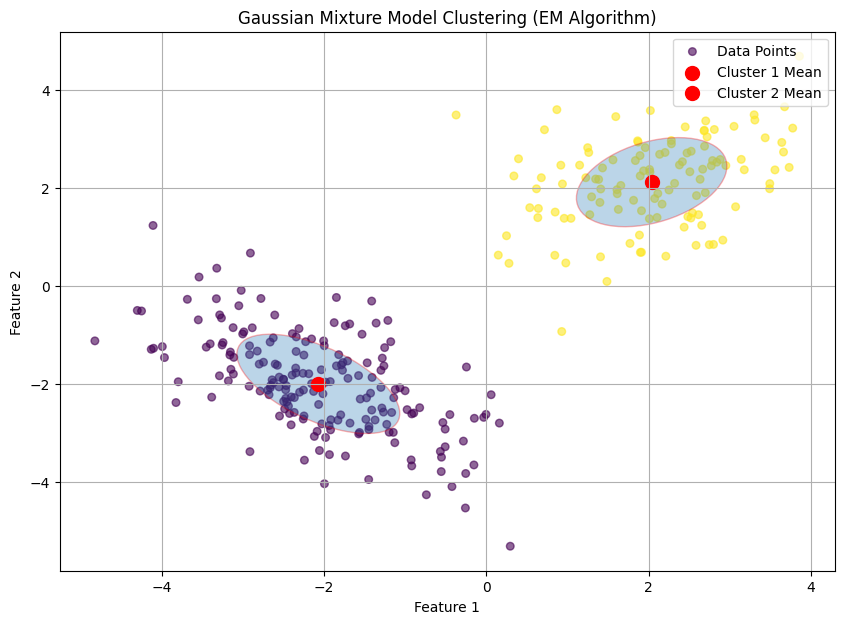

In [106]:
import matplotlib.pyplot as plt

# Visualize results
plot_2d_mix_guassian(X.numpy(), means, covariances, labels)




In [107]:
#| hide
import nbdev; nbdev.nbdev_export()